##Анализ и прогнозирование временного ряда.

Киреев Андрей ИУ5-64Б

Цель лабораторной работы: изучение основных методов анализа и прогнозирование временных рядов.

Задание:
Выберите набор данных (датасет) для решения задачи прогнозирования временного ряда.
Визуализируйте временной ряд и его основные характеристики.
Разделите временной ряд на обучающую и тестовую выборку.
Произведите прогнозирование временного ряда с использованием как минимум двух методов.
Визуализируйте тестовую выборку и каждый из прогнозов.
Оцените качество прогноза в каждом случае с помощью метрик.

In [33]:
# импортируем необходимые библиотеки
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

Возьмем датасет о количестве родившихся в n-ную дату.

In [34]:
births = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/births.csv")
births.head()

,Date,Births
0,1959-01-01,35
1,1959-01-02,32
2,1959-01-03,30
3,1959-01-04,31
4,1959-01-05,44


In [35]:
# превратим дату в индекс и сделаем изменение постоянным
births.set_index('Date', inplace = True)
births.head()

,Births
Date,
1959-01-01,35
1959-01-02,32
1959-01-03,30
1959-01-04,31
1959-01-05,44


In [36]:
# превратим дату (наш индекс) в объект datetime
births.index = pd.to_datetime(births.index)

In [37]:
births.dtypes

Births    int64
dtype: object

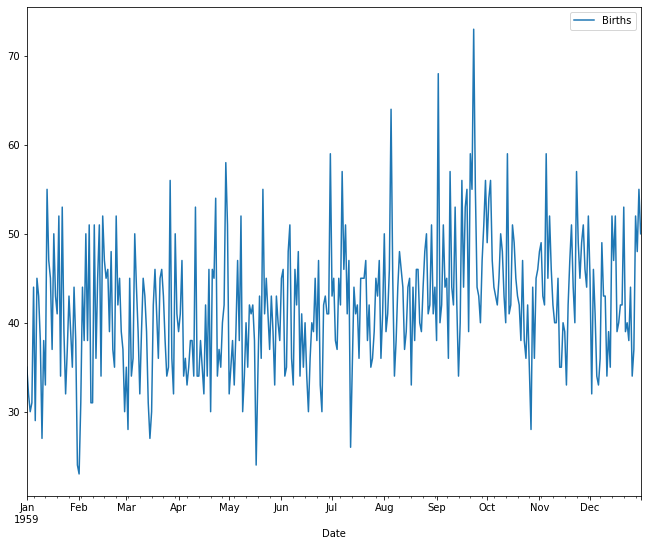

In [38]:
births.plot()

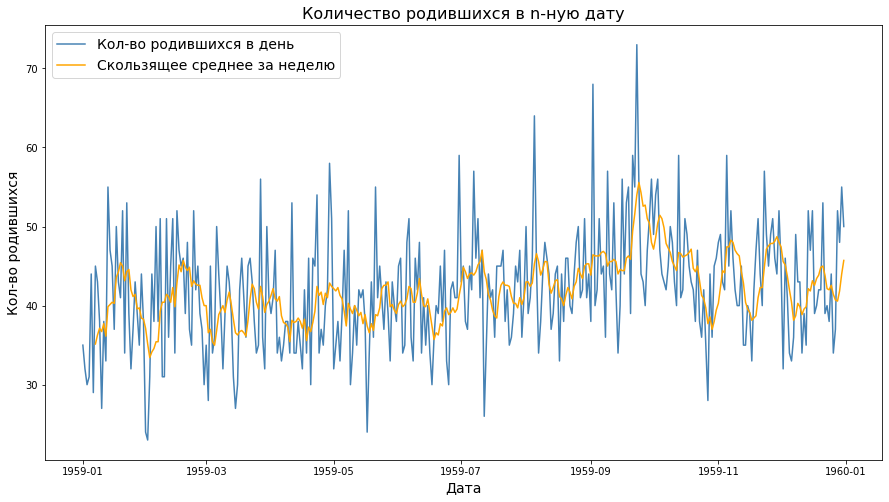

In [39]:
plt.figure(figsize = (15,8))

plt.plot(births, label = 'Кол-во родившихся в день', color = 'steelblue')
plt.plot(births.rolling(window = 7).mean(), label = 'Скользящее среднее за неделю', color = 'orange')

# добавим легенду, ее положение на графике и размер шрифта
plt.legend(title = '', loc = 'upper left', fontsize = 14)

# добавим подписи к осям и заголовки
plt.ylabel('Кол-во родившихся', fontsize = 14)
plt.xlabel('Дата', fontsize = 14)
plt.title('Количество родившихся в n-ную дату', fontsize = 16)

# выведем обе кривые на одном графике
plt.show()

Разложим наш временной ряд о рождениях на компоненты.

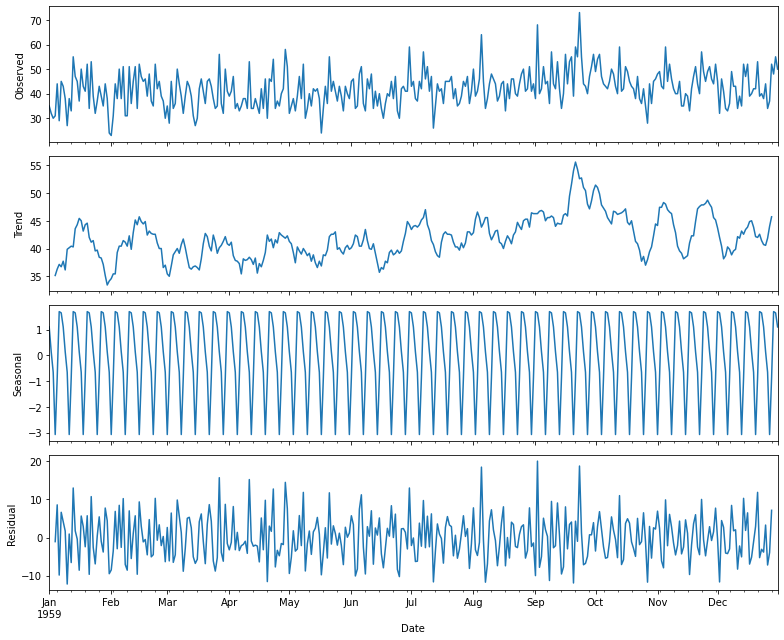

In [40]:
from statsmodels.tsa.seasonal import seasonal_decompose

# задаем размер графика
from pylab import rcParams
rcParams['figure.figsize'] = 11, 9

# применяем функцию к данным о перевозках
decompose = seasonal_decompose(births, model='additive', filt=None)
decompose.plot()

plt.show()

Из графиков видно, что Тренда изменения уровня ряда не наблюдается, однако прослеживается циклическая Сезонность, но ее можно списать на непрогнозируемые Случайные колебания.

In [41]:
# проведем тест Дики-Фуллера

from statsmodels.tsa.stattools import adfuller

# передадим ей столбец с данными о перевозках и поместим результат в adf_test
adf_test = adfuller(births['Births'])

# выведем p-value
print('p-value = ' + str(adf_test[1]))

p-value = 5.2434129901498554e-05


Результат существенно меньше 5%. Временной ряд стационарен. (то же самое мы можем наблюдать из графиков)

Проведем автокорреляцию - процес, показывающий степень взаимосвязи в одной и той же переменной в разные моменты времени.

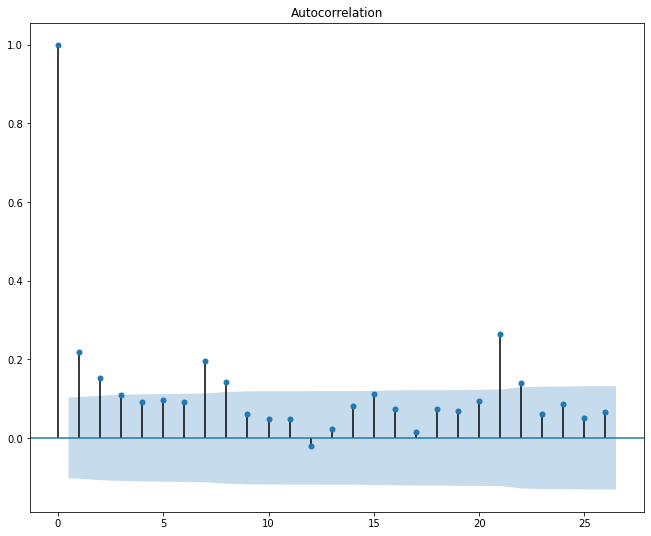

In [42]:
from statsmodels.graphics.tsaplots import plot_acf
 
plot_acf(births)
plt.show()

Здесь автокорреляция достаточно слабая, а также не прослеживаются сезонность и тренд.

Проведем прогнозирование временного ряда

In [43]:
!pip install statsmodels

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [44]:
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.holtwinters import ExponentialSmoothing

Разделим выборку на обучающую и тестовую: 70% к 30%.

In [45]:
# Целочисленная метка шкалы времени 
xnum = list(range(births.shape[0]))
# Разделение выборки на обучающую и тестовую
Y = births['Births'].values
train_size = int(len(Y) * 0.7)
xnum_train, xnum_test = xnum[0:train_size], xnum[train_size:]
train, test = Y[0:train_size], Y[train_size:]
history_arima = [x for x in train]
history_es = [x for x in train]

Создадим предсказания модели.

In [46]:
# Параметры модели (p,d,q) 
arima_order = (6, 1, 0)
# Формирование предсказаний
predictions_arima = list()
for t in range(len(test)):
    model_arima = ARIMA(history_arima, order=arima_order)
    model_arima_fit = model_arima.fit()
    yhat_arima = model_arima_fit.forecast()[0]
    predictions_arima.append(int(yhat_arima))
    history_arima.append(test[t])

In [47]:
# Записываем предсказания в DataFrame
births['predictions_ARIMA'] = (train_size * [np.NAN]) + list(predictions_arima)

In [48]:
from matplotlib import pyplot
import matplotlib.pyplot as plt

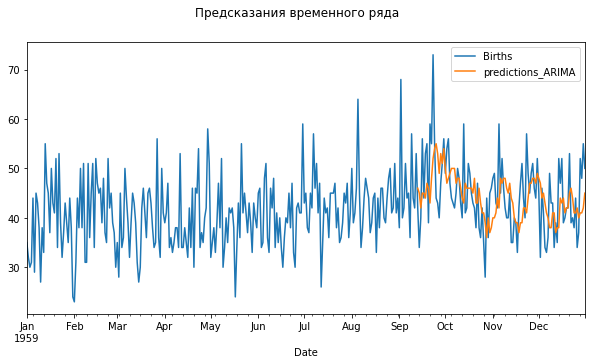

In [49]:
fig, ax = pyplot.subplots(1, 1, sharex='col', sharey='row', figsize=(10,5))
fig.suptitle('Предсказания временного ряда')
births.plot(ax=ax, legend=True)
pyplot.show()

Судя по графику предсказания отдаленно похожи, однако применим метрики:

In [51]:
from sklearn.metrics import r2_score, mean_squared_error

In [53]:
error_arima_mse = mean_squared_error(test, predictions_arima, squared=False)
print("MSE:",error_arima_mse)
error_arima_r2 = r2_score(test, predictions_arima)
print("R2:",error_arima_r2)

MSE: 7.131874673859347
R2: 0.020258653625735645


Согласно метрикам прогноз не является точным. Присутствует среднеквадратическая ошибка и коэффициент детерминации близок к нулю.

Попробуем спрогнозировать выборку данной моделью на 2 месяца вперед.

In [60]:
a = pd.to_datetime("1960-01-01")
new_dates_list = []
# Параметры модели (p,d,q) 
arima_order = (6, 1, 0)
# Формирование предсказаний
predictions_arima = list()
for t in range(60):
    new_dates_list.append(a)
    a = a + pd.Timedelta("1 day")
    model_arima = ARIMA(history_arima, order=arima_order)
    model_arima_fit = model_arima.fit()
    yhat_arima = model_arima_fit.forecast()[0]
    predictions_arima.append(int(yhat_arima))
    history_arima.append(test[t])


In [61]:
print(len(predictions_arima))
print(len(new_dates_list))

60
60


In [ ]:
births = births.drop('predictions_ARIMA', 1)

In [63]:
pred = pd.DataFrame({'Date': new_dates_list, "Births": predictions_arima})

In [64]:
# превратим дату в индекс и сделаем изменение постоянным
pred.set_index('Date', inplace = True)
pred.head()

,Births
Date,
1960-01-01,46
1960-01-02,43
1960-01-03,42
1960-01-04,40
1960-01-05,44


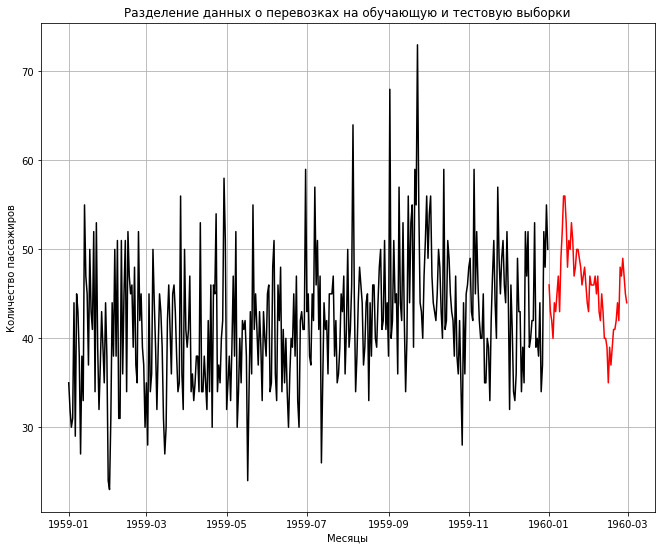

In [65]:
plt.plot(births, color = "black")
plt.plot(pred, color = "red")
 
# заголовок и подписи к осям
plt.title('Разделение данных о перевозках на обучающую и тестовую выборки')
plt.ylabel('Количество пассажиров')
plt.xlabel('Месяцы')
 
# добавим сетку
plt.grid()
 
plt.show()

Прогноз получился похожим по форме, однако с малыми колебаниями.

Теперь сравним с прогнозом по модели Хольта-Винтера (ExponentialSmoothing)

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


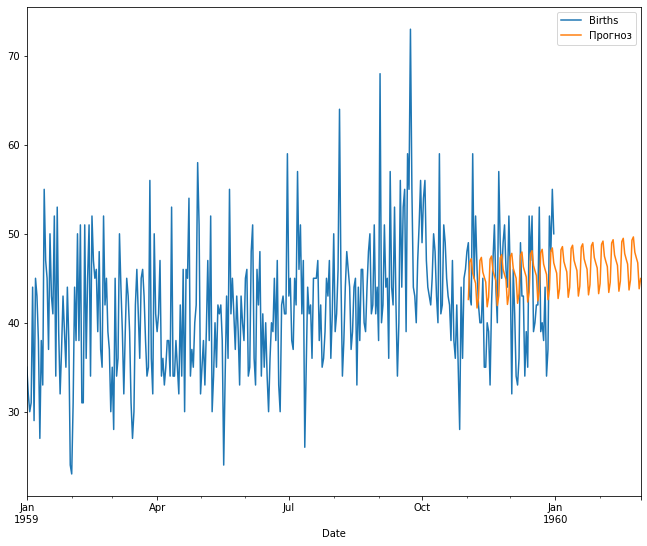

In [66]:
train = births[:'1959-11-01']
test = births['1959-11-02':]
fitted_model = ExponentialSmoothing(train, trend = 'mul', seasonal = 'mul').fit()
test_predictions = fitted_model.forecast(120)
births.plot(legend = True, label = 'Тренировочные данные')
test_predictions.plot(legend = True, label = 'Прогноз')

Экспоненциальное сглаживание не дало необходимого результата. Применим метрики:

In [67]:
test_predictions = fitted_model.forecast(60)

In [69]:
error_exp_smooth_mse = mean_squared_error(test, test_predictions, squared=False)
print("MSE:",error_exp_smooth_mse)
error_exp_smooth_r2 = r2_score(test, test_predictions)
print("R2:",error_exp_smooth_r2)

MSE: 6.882579575628301
R2: -0.13851710338541512


Здесь метрики показали еще более худший результат. Значит модель ARIMA является более предпочтительной, но не результативной для данного датасета.